In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
import random
from collections import deque
from lion_pytorch import Lion

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

class replay_buffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=self.capacity)

    def store(self, observation, action, reward, next_observation, done):
        observation = np.expand_dims(observation, 0)
        next_observation = np.expand_dims(next_observation, 0)
        self.memory.append([observation, action, reward, next_observation, done])

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        observations, actions, rewards, next_observations, dones = zip(* batch)
        return np.concatenate(observations, 0), actions, rewards, np.concatenate(next_observations, 0), dones

    def __len__(self):
        return len(self.memory)

class GMDQN(nn.Module):
    def __init__(self, in_features, out_features, n0, hidden_dim):
        super(GMDQN, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n0 = n0
        self.hidden_dim = hidden_dim
        self.nn_layer = nn.Sequential(
            nn.Linear(self.in_features, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
        )
        self.pi_layer = nn.Linear(self.hidden_dim, self.out_features * self.n0)
        self.mu_layer = nn.Linear(self.hidden_dim, self.out_features * self.n0)
        self.sigma_layer = nn.Linear(self.hidden_dim, self.out_features * self.n0)
        

    def forward(self, minibatch):
        out = self.nn_layer(minibatch)
        pi = nn.Softmax(dim=-1)(self.pi_layer(out).reshape(-1, self.out_features, self.n0))
        sigma = self.sigma_layer(out).reshape(-1, self.out_features, self.n0)
        mu = self.mu_layer(out).reshape(-1, self.out_features, self.n0)
        return pi, sigma, mu

    def act(self, input, epsilon):
        if random.random() >= epsilon:
            pi, sigma, mu = self.forward(input)
            q_value = (pi * mu).sum(-1)
            action = q_value.argmax(-1)
        else:
            action = random.choice(list(range(self.out_features)))
        return action



class CramerUnit(nn.Module):
    def __init__(self):
        super().__init__()
        # antiderivative of Phi (CDF of N(0,1)) is F.gelu(z) + sqrt(1/(2*pi)) * exp(-z**2/2)
        self.unit = lambda z: 2 * F.gelu(z) - z + 0.7978845608028654 * torch.exp(-z**2/2)
    def forward(self, m1, s1, m2, s2):
        v = torch.sqrt(s1**2+s2**2 + 1e-6) 
        return v*self.unit((m1-m2)/v)
        # This function is 1-Lipschitz
    

cramer = CramerUnit()
def train(buffer, target_model, eval_model, gamma, optimizer, batch_size, count, update_freq):

    observation, action, reward, next_observation, done = buffer.sample(batch_size)

    observation = torch.FloatTensor(observation)
    action = torch.LongTensor(action)
    reward = torch.FloatTensor(reward)
    next_observation = torch.FloatTensor(next_observation)
    done = torch.FloatTensor(done)
    batch_size_range = torch.arange(batch_size)

    pi, sigma, mu = eval_model.forward(observation)
    n0 = mu.size(-1)

    # see https://stackoverflow.com/questions/53986301/how-can-i-select-single-indices-over-a-dimension-in-pytorch
    sigma = sigma[batch_size_range, action]
    mu = mu[batch_size_range, action]
    pi = pi[batch_size_range, action]
    with torch.no_grad():
        next_pi, next_sigma, next_mu = target_model.forward(next_observation)
        argmax_actions = eval_model.act(next_observation, 0) # no randomness

        next_sigma = next_sigma[batch_size_range, argmax_actions]
        next_mu = next_mu[batch_size_range, argmax_actions]
        next_pi = next_pi[batch_size_range, argmax_actions]
        next_mu = gamma * next_mu * (1. - done.unsqueeze(-1)) + reward.unsqueeze(-1)
        next_sigma = gamma * next_sigma * (1. - done.unsqueeze(-1))
        
        next_mu_i = next_mu.unsqueeze(-1).repeat([1, 1, n0])
        next_mu_j = next_mu.unsqueeze(-2).repeat([1, n0, 1])
        next_sigma_i = next_sigma.unsqueeze(-1).repeat([1, 1, n0])
        next_sigma_j = next_sigma.unsqueeze(-2).repeat([1, n0, 1])
        next_pi_i = next_pi.unsqueeze(-1).repeat([1, 1, n0])
        next_pi_j = next_pi.unsqueeze(-2).repeat([1, n0, 1])

    mu_i = mu.unsqueeze(-1).repeat([1, 1, n0])
    mu_j = mu.unsqueeze(-2).repeat([1, n0, 1])
    sigma_i = sigma.unsqueeze(-1).repeat([1, 1, n0])
    sigma_j = sigma.unsqueeze(-2).repeat([1, n0, 1])
    pi_i = pi.unsqueeze(-1).repeat([1, 1, n0])
    pi_j = pi.unsqueeze(-2).repeat([1, n0, 1])

    first_item = pi_i * pi_j * cramer(mu_i, sigma_i, mu_j, sigma_j)
    second_item = next_pi_i * next_pi_j * cramer(next_mu_i, next_sigma_i, next_mu_j, next_sigma_j)
    third_item = pi_i * next_pi_j * cramer(mu_i, sigma_i, next_mu_j, next_sigma_j)
    # We don't want sigmas to be negative. That has no mathematical meaning.
    penalty_item = nn.ReLU()(-10*sigma).sum()
    loss = (2*third_item.sum() -first_item.sum() -second_item.sum() + penalty_item) / batch_size

    optimizer.zero_grad()
    loss.backward()
    # not really useful if loss function is Lipschitz (will prove later)
    nn.utils.clip_grad_norm_(eval_model.parameters(), 10) 
    optimizer.step()
    if count % update_freq == 0:
        target_model.load_state_dict(eval_model.state_dict())




In [16]:

gamma = 0.99
learning_rate = 5e-5
learning_rate_2 = 5e-9

batch_size = 64
update_freq = 200
capacity = 100000
exploration = 60
epsilon_init = 0.6
epsilon_min = 0.01
decay = 0.993
episode = 1000000
render = False
n0 = 3 # number of Gaussians
hidden_dim = 128

seed = 20230501
set_seed(seed)
env = gym.make('LunarLander-v2')
# env = env.unwrapped
# env.seed(seed)
observation_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
target_net = GMDQN(observation_dim, action_dim, n0, hidden_dim)
eval_net = GMDQN(observation_dim, action_dim, n0, hidden_dim)
target_net.load_state_dict(eval_net.state_dict())
target_net.train(False)
'''
optimizer = torch.optim.Adam([
    {"params":eval_net.nn_layer.parameters()},
    {"params":eval_net.mu_layer.parameters()},
    {"params":eval_net.sigma_layer.parameters()},
    ], lr=learning_rate)
optimizer2 = torch.optim.RMSprop(eval_net.pi_layer.parameters(), lr=learning_rate_2)
'''
optimizer = Lion([
    {"params": eval_net.nn_layer.parameters(), "lr": learning_rate},
    {"params": eval_net.mu_layer.parameters(), "lr": learning_rate},
    {"params": eval_net.sigma_layer.parameters(), "lr": learning_rate},
    {"params": eval_net.pi_layer.parameters(), "lr": learning_rate_2},
    ])

buffer = replay_buffer(capacity)
epsilon = epsilon_init
count = 0

weight_reward = None
for i in range(episode):
    obs, _ = env.reset()
    if epsilon > epsilon_min:
        epsilon = epsilon * decay
    reward_total = 0
    if render:
        env.render()
    while True:
        action = eval_net.act(torch.FloatTensor(np.expand_dims(obs, 0)), epsilon)
        count += 1
        next_obs, reward, done, timeup, info = env.step(int(action))
        buffer.store(obs, action, reward, next_obs, done)
        reward_total += reward
        obs = next_obs
        if render:
            env.render()
        if i > exploration:
            train(buffer, target_net, eval_net, gamma, optimizer, batch_size, count, update_freq)

        if done or timeup:
            if not weight_reward:
                weight_reward = reward_total
            else:
                weight_reward = 0.95 * weight_reward + 0.05 * reward_total
            print('episode: {}\tepsilon: {:.2f}\treward: {:.2f}\tweight_reward: {:.3f}'.format(i+1, epsilon, reward_total, weight_reward))
            break
    if weight_reward > 260 and reward_total > 303 and epsilon < 0.011:
        break

episode: 1	epsilon: 0.60	reward: -236.88	weight_reward: -236.876
episode: 2	epsilon: 0.59	reward: -486.91	weight_reward: -249.377
episode: 3	epsilon: 0.59	reward: -545.54	weight_reward: -264.186
episode: 4	epsilon: 0.58	reward: -337.15	weight_reward: -267.834
episode: 5	epsilon: 0.58	reward: -756.41	weight_reward: -292.263
episode: 6	epsilon: 0.58	reward: -454.95	weight_reward: -300.397
episode: 7	epsilon: 0.57	reward: -402.75	weight_reward: -305.515
episode: 8	epsilon: 0.57	reward: -199.76	weight_reward: -300.227
episode: 9	epsilon: 0.56	reward: -462.64	weight_reward: -308.347
episode: 10	epsilon: 0.56	reward: -634.09	weight_reward: -324.635
episode: 11	epsilon: 0.56	reward: -271.91	weight_reward: -321.999
episode: 12	epsilon: 0.55	reward: -221.64	weight_reward: -316.981
episode: 13	epsilon: 0.55	reward: -170.71	weight_reward: -309.667
episode: 14	epsilon: 0.54	reward: -558.80	weight_reward: -322.124
episode: 15	epsilon: 0.54	reward: -99.35	weight_reward: -310.985
episode: 16	epsilon:

In [17]:
action_names = {
0: 'noop',
1: 'left',
2: 'main',
3: 'right',
}

In [18]:
L0=None
R0=None
def plot_gaussian(pi, mu, sigma, ax=None):
    global L0,R0
    pi = pi.squeeze(0).detach().numpy()
    mu = mu.squeeze(0).detach().numpy()
    sigma = sigma.squeeze(0).detach().numpy()
    c = 1/math.sqrt(2*math.pi)
    # print(pi.shape)
    i0,j0 = pi.shape
    if ax is None:
        ax = plt.gca()
    L=np.min(np.sum(pi*(mu-4*sigma), axis=-1))
    R=np.max(np.sum(pi*(mu+4*sigma), axis=-1))
    if L0==None: L0,R0 = L,R
    else: 
        L0=0.75*L0 +0.25*L
        R0=0.75*R0 +0.25*R
    xs=np.linspace(L0, R0, 100)
    G=np.zeros((i0,100))

    for i in range(i0):
        for j in range(j0):
            G[i]+=pi[i][j] * np.exp(- ((xs-mu[i][j])/sigma[i][j])**2 / 2) / sigma[i][j]
    
    G *= c
    for i in range(i0):
        ax.plot(xs, G[i], label=f'{i}:{action_names[i]}')
    ax.legend()

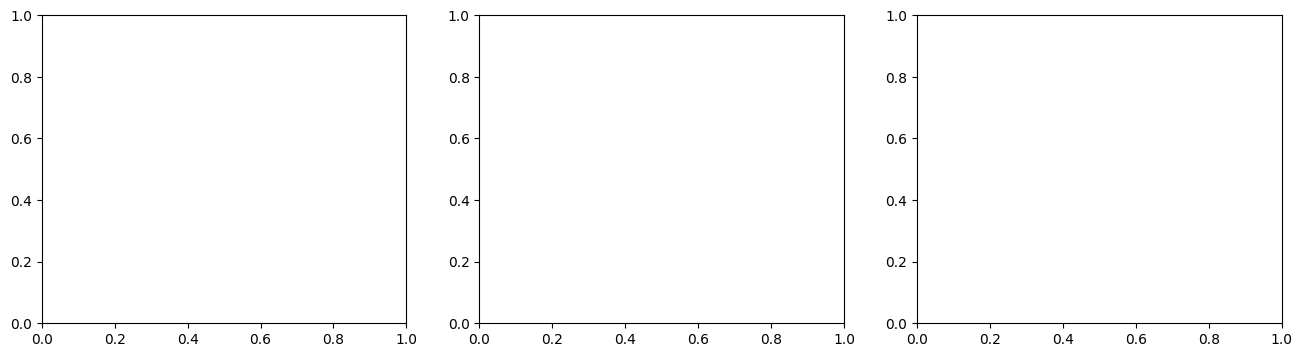

In [35]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import math
from IPython import display

fig,[ax1,ax2,ax3]=plt.subplots(1,3,figsize=(16,4))

env = gym.make('LunarLander-v2', render_mode="rgb_array")
obs, _ = env.reset()
scores = [0.0]
score = 0.0


In [36]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='SlicedCramerGMM',
                comment='Sliced Cramer GMM learning process')
writer = FFMpegWriter(fps=6, metadata=metadata)

In [37]:
with writer.saving(fig, "LunarLander_20230430_1.mp4", 100):
    def plot_once():
        ax1.clear()
        ax1.imshow(env.render())
        ax1.set_title('Env',fontsize=15)

        ax2.clear()
        pi, sigma, mu = eval_net.forward(torch.FloatTensor(np.expand_dims(obs, 0)))
        plot_gaussian(pi, mu, sigma, ax2)
        ax2.set_title('Distribs',fontsize=15)

        ax3.clear()
        ax3.plot(np.asarray(scores), c='k', linewidth=1)
        ax3.set_title('Scores',fontsize=15)

        display.clear_output(wait=False)
        display.display(plt.gcf())
        display.clear_output(wait=False)
        display.display(plt.gcf())
        # time.sleep(1e-3)
        writer.grab_frame()
    
    while True:
        action = eval_net.act(torch.FloatTensor(np.expand_dims(obs, 0)), epsilon)
        count += 1
        plot_once()
        next_obs, reward, done, timeup, info = env.step(int(action))
        score += reward
        scores.append(score)
        obs = next_obs
        if done or timeup:
            plot_once()
            plot_once()
            print(score)
            break

<Figure size 640x480 with 0 Axes>

284.6108184830345


<Figure size 640x480 with 0 Axes>

In [34]:
for i in range(20):
    score=0
    env = gym.make('LunarLander-v2', render_mode="None")
    obs, _ = env.reset()
    while True:
        action = eval_net.act(torch.FloatTensor(np.expand_dims(obs, 0)), 0)
        next_obs, reward, done, timeup, info = env.step(int(action))
        score += reward
        obs = next_obs
        if done or timeup:
            print(score)
            break

285.75242006855103
253.75041319828728
296.9199410323822
287.10466677565887
294.53906061091755
242.88441146668083
301.1432398510539
269.5037583121077
291.74352875747593
262.23754662092256
289.7306632734171
264.829424097279
297.5387630811417
283.39621507085394
248.85075868661622
272.07667142225023
287.6903896753847
279.11446623282643
265.88801664930884
248.51362950479864


In [25]:
for i in range(episode):
    obs, _ = env.reset()
    if epsilon > epsilon_min:
        epsilon = epsilon * decay
    reward_total = 0
    if render:
        env.render()
    while True:
        action = eval_net.act(torch.FloatTensor(np.expand_dims(obs, 0)), epsilon)
        count += 1
        next_obs, reward, done, timeup, info = env.step(int(action))
        buffer.store(obs, action, reward, next_obs, done)
        reward_total += reward
        obs = next_obs
        if render:
            env.render()
        if i > exploration:
            train(buffer, target_net, eval_net, gamma, optimizer, batch_size, count, update_freq)

        if done or timeup:
            if not weight_reward:
                weight_reward = reward_total
            else:
                weight_reward = 0.95 * weight_reward + 0.05 * reward_total
            print('episode: {}\tepsilon: {:.2f}\treward: {:.2f}\tweight_reward: {:.3f}'.format(i+1, epsilon, reward_total, weight_reward))
            break
    if weight_reward > 265 and reward_total > 303 and i>100:
        break

episode: 1	epsilon: 0.01	reward: 236.11	weight_reward: 260.824
episode: 2	epsilon: 0.01	reward: 315.57	weight_reward: 263.561
episode: 3	epsilon: 0.01	reward: 205.79	weight_reward: 260.672
episode: 4	epsilon: 0.01	reward: 246.02	weight_reward: 259.940
episode: 5	epsilon: 0.01	reward: 280.21	weight_reward: 260.953
episode: 6	epsilon: 0.01	reward: 302.73	weight_reward: 263.042
episode: 7	epsilon: 0.01	reward: 265.07	weight_reward: 263.143
episode: 8	epsilon: 0.01	reward: 264.09	weight_reward: 263.190
episode: 9	epsilon: 0.01	reward: 268.68	weight_reward: 263.465
episode: 10	epsilon: 0.01	reward: 187.36	weight_reward: 259.660
episode: 11	epsilon: 0.01	reward: 207.91	weight_reward: 257.072
episode: 12	epsilon: 0.01	reward: 193.82	weight_reward: 253.909
episode: 13	epsilon: 0.01	reward: 233.70	weight_reward: 252.899
episode: 14	epsilon: 0.01	reward: 206.10	weight_reward: 250.559
episode: 15	epsilon: 0.01	reward: 255.30	weight_reward: 250.796
episode: 16	epsilon: 0.01	reward: 250.31	weight_r

In [40]:
torch.save(eval_net,"./gm_dqn.pth")